# GLMM

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gpboost as gpb
from patsy import dmatrix
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
filepath = '../../../../data/processed/df_filtered_5years_exclude_too_far_islands.xlsx'
df = pd.read_excel(filepath)
df = df[df['island_id'] != 191] # この島は変化率が無限大になるので除外
df.dropna(inplace=True)

In [3]:
df['population_change_rate'] = df.groupby('island_id')['population'].pct_change()
df['log_income'] = np.log(df['income'])
df['log_area'] = np.log(df['area_km2'])
df['log_distance'] = np.log(df['distance_m'])
df = df.dropna()

# モデリング

$$
Population_{it} = \alpha_{it} + \mathbf{X}^T_{it}\beta_{it} + \text{T}_{it}\mathbf{X}^T_{it}\gamma_{it} + \delta_{it}\text{Year}_i + \epsilon_{it}
$$

In [6]:
group = df['island_id']
y = df['population_change_rate']
X = dmatrix('log_income + log_area + log_distance + dummy_after_bridge_opened * log_income + dummy_after_bridge_opened * log_area + dummy_after_bridge_opened * log_distance + C(year)', data=df, return_type='dataframe')

model = gpb.GPModel(group_data=group, likelihood='gaussian') # 正規分布
model.fit(y=y, X=X, params={'std_dev': True})

pred = model.predict(X_pred=X, group_data_pred=group)['mu']
residuals = y - pred

print(model.summary())

Model summary:
 Log-lik     AIC     BIC
  222.06 -412.11 -346.51
Nb. observations: 446
Nb. groups: 90 (island_id)
-----------------------------------------------------
Covariance parameters (random effects):
            Param.  Std. dev.
Error_term  0.0216     0.0016
island_id   0.0000     0.0007
-----------------------------------------------------
Linear regression coefficients (fixed effects):
                                        Param.  Std. dev.  z value  P(>|z|)
Intercept                              -0.1057     0.1393  -0.7592   0.4477
C(year)[T.1995]                         0.0049     0.1347   0.0365   0.9709
C(year)[T.2000]                        -0.0159     0.1078  -0.1471   0.8831
C(year)[T.2005]                         0.0486     0.1081   0.4493   0.6532
C(year)[T.2010]                        -0.0040     0.1082  -0.0370   0.9705
C(year)[T.2015]                        -0.0199     0.1082  -0.1841   0.8540
C(year)[T.2020]                        -0.0493     0.1082  -0.4553  

In [64]:
group = df['island_id']
y = df['population_change_rate']
X = dmatrix('dummy_after_bridge_opened + log_income + log_area + log_distance + C(year)', data=df, return_type='dataframe')
random_slope_var = df[['dummy_after_bridge_opened']]

ind_effect_group_rand_coef = [6]

model = gpb.GPModel(
    group_data=group,
    group_rand_coef_data=random_slope_var,
    ind_effect_group_rand_coef=ind_effect_group_rand_coef,
    likelihood='gaussian' # 正規分布
    )
model.fit(y=y, X=X, params={'std_dev': True})

# pred = model.predict(X_pred=X, group_data_pred=group)['mu']
# residuals = y - pred

print(model.summary())

IndexError: list index out of range

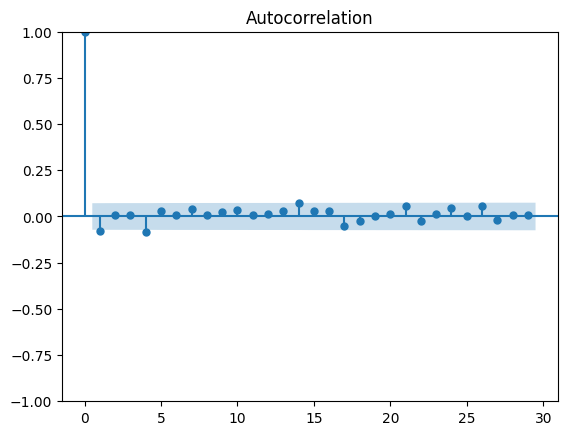

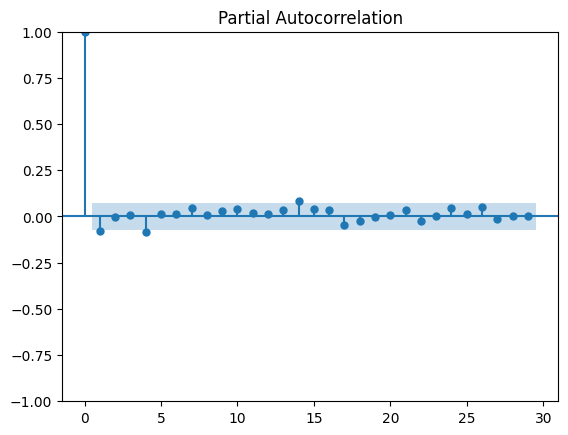

In [36]:
# ACF plot
plot_acf(residuals)
plt.show()

# PACF plot
plot_pacf(residuals)
plt.show()